# Fast Efficient & Lossless Image Compression System (FELICS)

### L'Image

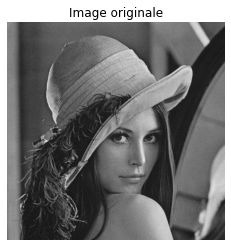

In [32]:
# Chargement des bibliothèques

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Chargement de l'image

image_path = 'Lenna.png'
image = Image.open(image_path)
image = image.convert('L')  # Convertir l'image en niveaux de gris
image_array = np.array(image)
plt.imshow(image_array, cmap='gray')
plt.title('Image originale')
plt.axis('off')

#je veux que tu me save la matrice des valeurs d'intensité de l'image

# Sauvegarde de la matrice des valeurs d'intensité de l'image au format CSV
np.savetxt('image_array.csv', image_array, delimiter=',', fmt='%d')

### Histogramme

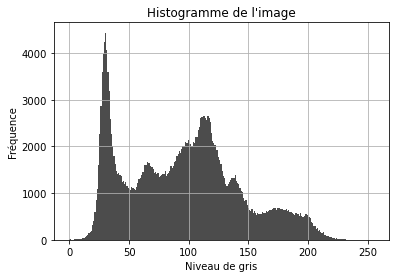

In [33]:
# Affichage de l'histogramme

plt.figure()
plt.hist(image_array.flatten(), bins=256, range=(0, 255), color='black', alpha=0.7)
plt.title('Histogramme de l\'image')
plt.xlabel('Niveau de gris')
plt.ylabel('Fréquence')
plt.grid()
plt.show()

## Les informations de l'imamge

L'entropie : 

$$ Entropy = \sum_{k=0}^{255} p_k \log_2(p_k)$$


In [34]:
def Entropy(matrice):
    # Calcul de l'entropie d'une matrice
    hist, _ = np.histogram(matrice.flatten(), bins=256, range=(0, 255), density=True)
    hist = hist[hist > 0]
    entropie = -np.sum(hist * np.log2(hist))
    return entropie

print("Entropie de l'image originale :", Entropy(image_array))

Entropie de l'image originale : 7.415894872349124


### L'algorithme de la compression FELICS

##### Etape I - Récupérer les 2 voisins les plus proches

###### Présentation des cas :

1. **Cas 1**:  
    ![Cas 1](images/cas1.png)  
    Pour les deux premiers bits, nous allons simplement coder les deux valeurs en binaire. On évite toute optimisation afin de ne pas perdre au change.

2. **Cas 2**:  
    ![Cas 2](images/cas2.png)  
    Dans ce second cas, on va utiliser comme références les deux pixels à la gauche directs.

3. **Cas 3**:  
    ![Cas 3](images/cas3.png)  
    Dans ce troisième cas, on va utiliser les deux pixels sur la ligne supérieure.

4. **Cas 4**:  
    ![Cas 4](images/cas4.png)  
    Cas le plus commun, on compare avec les pixels à la gauche et supérieur directs.

On peut alors noter ces cas de cette manière :

Une fois que l'on obtient ces deux coordonnées, on peut alors déterminer la valeur basse et la valeur haute. On les notera B et H respectivement.


In [35]:
# Les différentes Cas :

# Cas 1 : Pas besoin de récupérer des pixels de référence

# Cas 2 : Récupération de pixels de référence

def cas_2(coordonnees): 
    reference_coordonnees = [[0, coordonnees[1] - 2], [0, coordonnees[1] - 1]]
    return reference_coordonnees

# Cas 3 : Récupération de pixels de référence

def cas_3(coordonnees):
    reference_coordonnees = [[coordonnees[0] - 1, coordonnees[1]], [coordonnees[0] - 1, coordonnees[1] + 1]]
    return reference_coordonnees

# Cas 4 : Récupération de pixels de référence

def cas_4(coordonnees):
    reference_coordonnees = [[coordonnees[0] - 1, coordonnees[1]], [coordonnees[0], coordonnees[1] - 1]]
    return reference_coordonnees

def get_BH(images, coord1, coord2):
    val_1 = images[coord1[0], coord1[1]]
    val_2 = images[coord2[0], coord2[1]]
    if val_1 > val_2:
        return val_2, val_1
    else:
        return val_1, val_2

Une fois que l'on a récupéré les deux valeurs des pixels de référence, l'objectif est alors de calculer le contexte et, par la suite, de classifier la valeur de notre pixel par rapport à ce contexte. La classification est alors divisée en 3 différents cas. Le premier est le cas bas : la valeur du pixel est **strictement inférieure** à la valeur des deux pixels. Le second est le cas haut : dans ce cas, la valeur du pixel est **strictement supérieure** à la valeur des deux pixels de référence. Le dernier correspond à la position **entre** : on se retrouve alors dans cette position.

In [36]:
def get_context(P, H, B):
    # P : pixel de référence
    # H : Pixel haut
    # B : Pixel bas
    if P < B:
        return -1
    elif P > H:
        return 1
    else:
        return 0
    

On peut alors vérifier si l'hypothèse selon laquelle la valeur des pixels de référence se trouve le plus souvent entre la valeur basse et la valeur haute est vérifiée :


-1  :  117864
0  :  72187
1  :  72093
262144


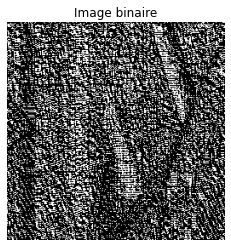

In [45]:
def test_get_context(image):
    h,w = image.shape
    result = []
    for i in range(h):
        for j in range(w):
            if i == 0 and j == 0 or i == 0 and j == 1:
                result.append(1)
            elif i == 0:
                coor = cas_2([i,j])
                get_BH(image, coor[0], coor[1])
                result.append(get_context(image[i,j], image[coor[0][0], coor[0][1]], image[coor[1][0], coor[1][1]]))
            elif j == 0:
                coor = cas_3([i,j])
                get_BH(image, coor[0], coor[1])
                result.append(get_context(image[i,j], image[coor[0][0], coor[0][1]], image[coor[1][0], coor[1][1]]))
            else:
                coor = cas_4([i,j])
                get_BH(image, coor[0], coor[1])
                result.append(get_context(image[i,j], image[coor[0][0], coor[0][1]], image[coor[1][0], coor[1][1]]))
    return result

result = test_get_context(image_array)

for i in range(-1,2):
    print(i, " : ", result.count(i))

print(len(result))

#je ceux une image en 256*256 avec des pixels noir si ca vaut -1 ou 1 et blanc si ca vaut 0

def create_image(result):
    h = 256
    w = 256
    image = np.zeros((h, w), dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if result[i * w + j] == -1 or result[i * w + j] == 1:
                image[i, j] = 0
            else:
                image[i, j] = 255
    return image
image_result = create_image(result)
plt.imshow(image_result, cmap='gray')
plt.title('Image binaire')
plt.axis('off')
plt.show()

#je veux que tu m'enregistre resultat dans un fichier csv
np.savetxt('result.csv', result, delimiter=',', fmt='%d')